In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile

extracted_dir = '/content/dataSPLIT20renamed'
zip_file_path = '/content/drive/My Drive/dataSPLIT20renamed.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.layers import Flatten

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.layers import Flatten


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model1.trainable = False
x = model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

model1 = Model(inputs=model1.input, outputs=predictions)
model1.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model_path = f'/content/model1res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]


history1 = model1.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)



Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
Epoch 1/40
76/76 [==============================] - ETA: 0s - loss: 3.3669 - accuracy: 0.1626
Epoch 1: val_accuracy improved from -inf to 0.72070, saving model to /content/model1res.keras
76/76 [==============================] - 26s 306ms/step - loss: 3.3669 - accuracy: 0.1626 - val_loss: 1.4862 - val_accuracy: 0.7207
Epoch 2/40
76/76 [==============================] - ETA: 0s - loss: 1.8721 - accuracy: 0.4505
Epoch 2: val_accuracy improved from 0.72070 to 0.82422, saving model to /content/model1res.keras
76/76 [==============================] - 12s 163ms/step - loss: 1.8721 - accuracy: 0.4505 - val_loss: 0.9048 - val_accuracy: 0.8242
Epoch 3/40
76/76 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.6065
Epoch 3: val_accuracy improved from 0.82422 to 0.86523, saving model to /content/model1res.keras
76/76 [==============================] 

In [ ]:
from tensorflow.keras.models import load_model

model1_loaded = load_model('/content/model1res.keras')

17/17 [==============================] - 3s 116ms/step


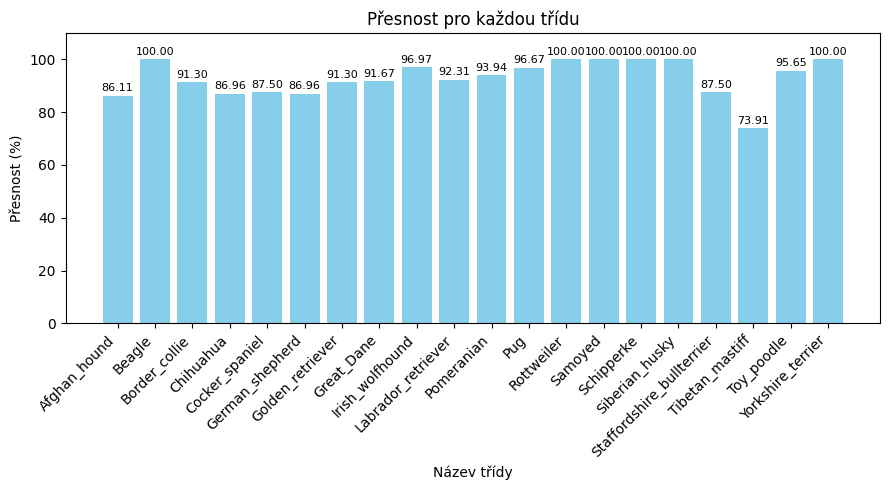

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model1_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()

17/17 [==============================] - 2s 113ms/step


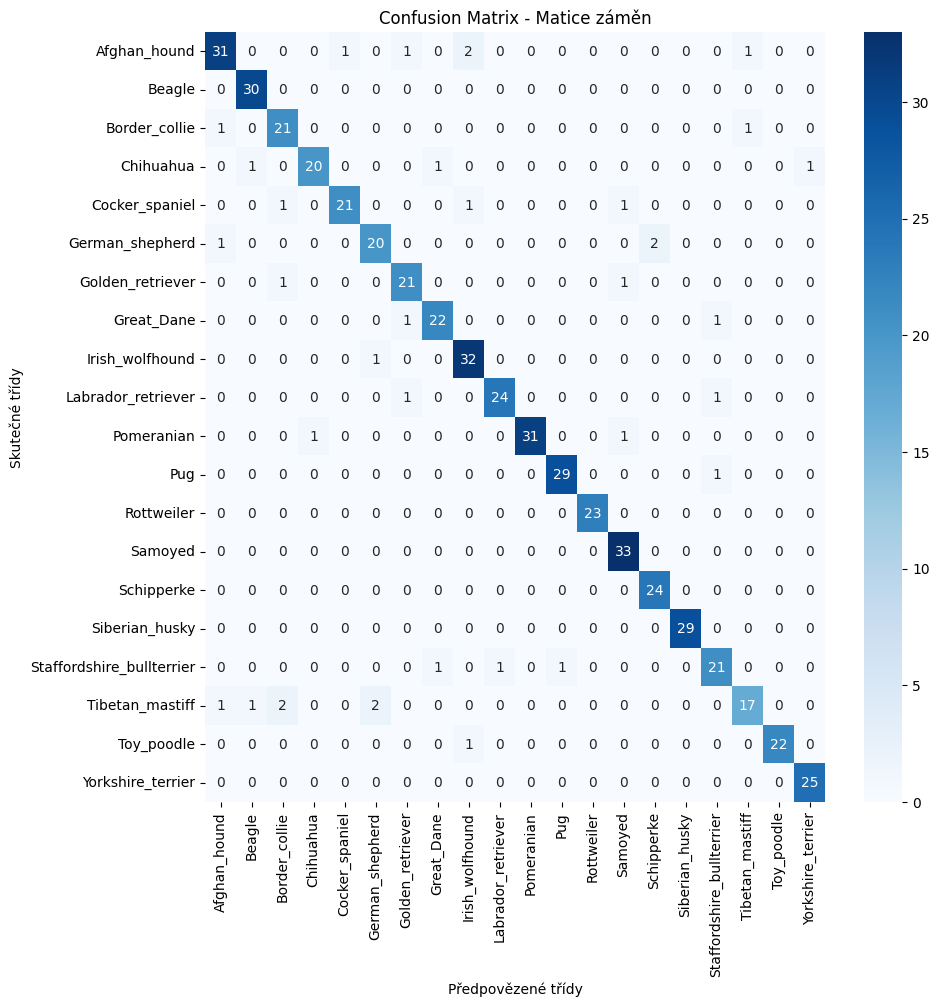

In [ ]:
predictions = model1_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

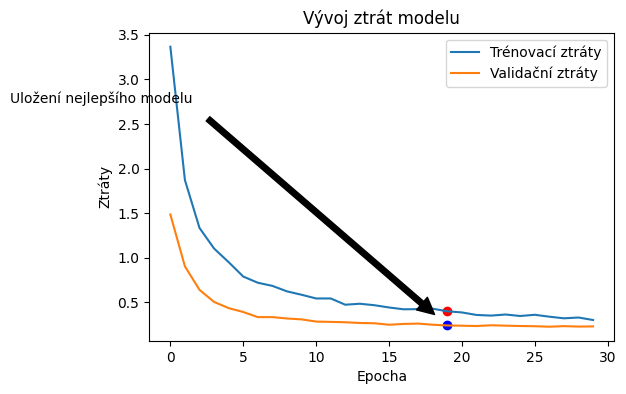

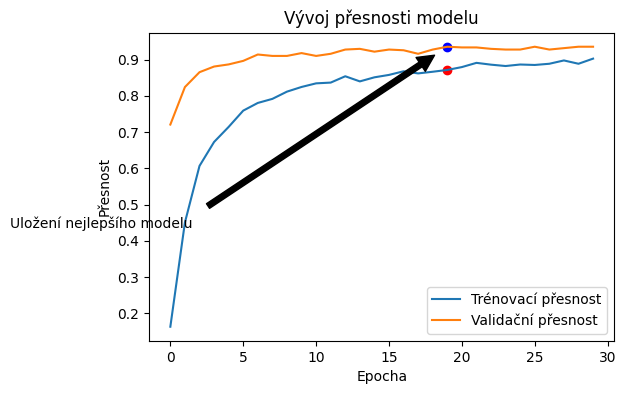

In [ ]:
import matplotlib.pyplot as plt

best_epoch = 19
best_loss = history1.history['loss'][best_epoch]
best_val_loss = history1.history['val_loss'][best_epoch]


plt.figure(figsize=(6, 4))
plt.plot(history1.history['loss'], label='Trénovací ztráty')
plt.plot(history1.history['val_loss'], label='Validační ztráty')
plt.scatter(best_epoch, best_loss, color='red')
plt.scatter(best_epoch, best_val_loss, color='blue')
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_loss), xytext=(best_epoch-30, best_val_loss+2.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


best_accuracy = history1.history['accuracy'][best_epoch]
best_val_accuracy = history1.history['val_accuracy'][best_epoch]

plt.figure(figsize=(6, 4))
plt.plot(history1.history['accuracy'], label='Trénovací přesnost')
plt.plot(history1.history['val_accuracy'], label='Validační přesnost')
plt.scatter(best_epoch, best_accuracy, color='red')
plt.scatter(best_epoch, best_val_accuracy, color='blue')
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')

plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_accuracy), xytext=(best_epoch-30, best_val_accuracy-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='constant'
)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)
model2.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model2_path = f'/content/model2res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model2_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]


history2 = model2.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
Epoch 1/70
76/76 [==============================] - ETA: 0s - loss: 3.4941 - accuracy: 0.1398
Epoch 1: val_accuracy improved from -inf to 0.65234, saving model to /content/model2res.keras
76/76 [==============================] - 40s 486ms/step - loss: 3.4941 - accuracy: 0.1398 - val_loss: 1.6340 - val_accuracy: 0.6523
Epoch 2/70
76/76 [==============================] - ETA: 0s - loss: 2.1222 - accuracy: 0.3715
Epoch 2: val_accuracy improved from 0.65234 to 0.80078, saving model to /content/model2res.keras
76/76 [==============================] - 36s 468ms/step - loss: 2.1222 - accuracy: 0.3715 - val_loss: 1.0149 - val_accuracy: 0.8008
Epoch 3/70
76/76 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.5399
Epoch 3: val_accuracy improved from 0.80078 to 0.87500, saving model to /content/model2res.keras
76/76 [==============================] 

In [ ]:
from tensorflow.keras.models import load_model

model2_loaded = load_model('/content/model2res.keras')

In [ ]:
predictions = model2_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

17/17 [==============================] - 2s 120ms/step


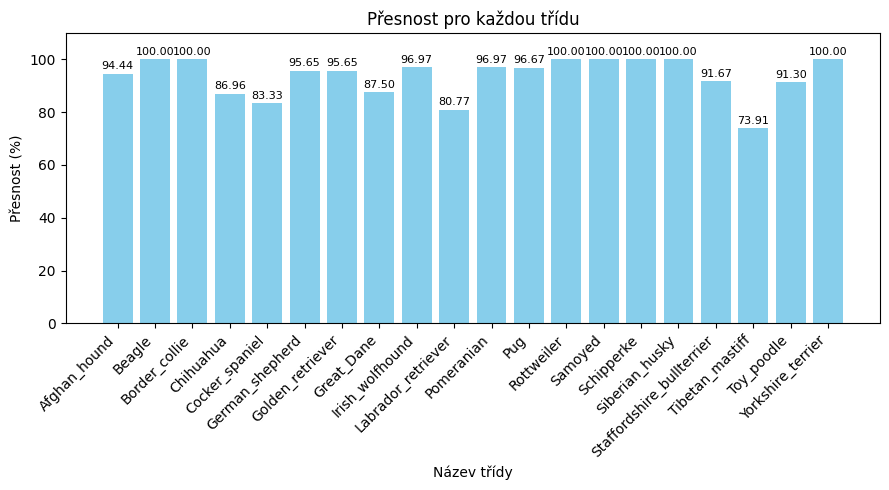

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model2_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()

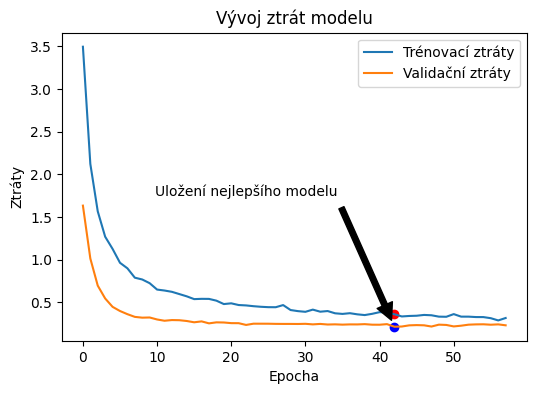

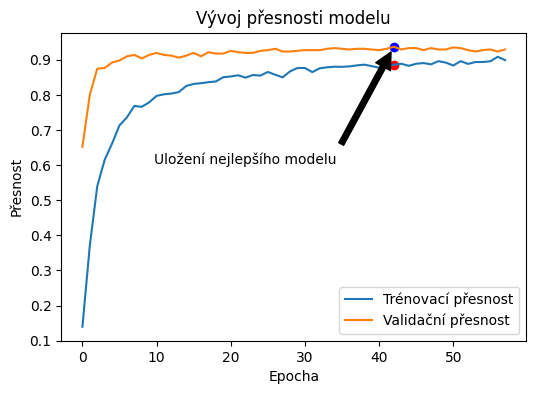

In [ ]:
import matplotlib.pyplot as plt


best_epoch = 42
best_loss = history2.history['loss'][best_epoch]
best_val_loss = history2.history['val_loss'][best_epoch]


plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Trénovací ztráty')
plt.plot(history2.history['val_loss'], label='Validační ztráty')
plt.scatter(best_epoch, best_loss, color='red')
plt.scatter(best_epoch, best_val_loss, color='blue')
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_loss),
             xytext=(best_epoch-20, best_val_loss+1.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='bottom')

plt.show()


best_accuracy = history2.history['accuracy'][best_epoch]
best_val_accuracy = history2.history['val_accuracy'][best_epoch]

plt.figure(figsize=(6, 4))
plt.plot(history2.history['accuracy'], label='Trénovací přesnost')
plt.plot(history2.history['val_accuracy'], label='Validační přesnost')
plt.scatter(best_epoch, best_accuracy, color='red')
plt.scatter(best_epoch, best_val_accuracy, color='blue')
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_accuracy),
             xytext=(best_epoch-20, best_val_accuracy-0.30),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='top')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model3 = tf.keras.models.clone_model(model2_loaded)
model3.set_weights(model2_loaded.get_weights())

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='constant'
)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




for layer in model3.layers[-15:]:
    layer.trainable = True

model3.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model3_path = f'/content/model3res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model3_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]

history_finetune = model3.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8727
Epoch 1: val_accuracy improved from -inf to 0.92773, saving model to /content/model3res.keras
76/76 [==============================] - 45s 490ms/step - loss: 0.4086 - accuracy: 0.8727 - val_loss: 0.2382 - val_accuracy: 0.9277
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8860
Epoch 2: val_accuracy did not improve from 0.92773
76/76 [==============================] - 36s 467ms/step - loss: 0.3538 - accuracy: 0.8860 - val_loss: 0.2382 - val_accuracy: 0.9258
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8956
Epoch 3: val_accuracy improved from 0.92773 to 0.93750, saving model to /content/model3res.keras
76/76 [==============================] - 34s 451ms/step - loss: 0.3283 - accuracy: 0.

In [ ]:
from tensorflow.keras.models import load_model

model3_loaded = load_model('/content/model3res.keras')

17/17 [==============================] - 3s 120ms/step


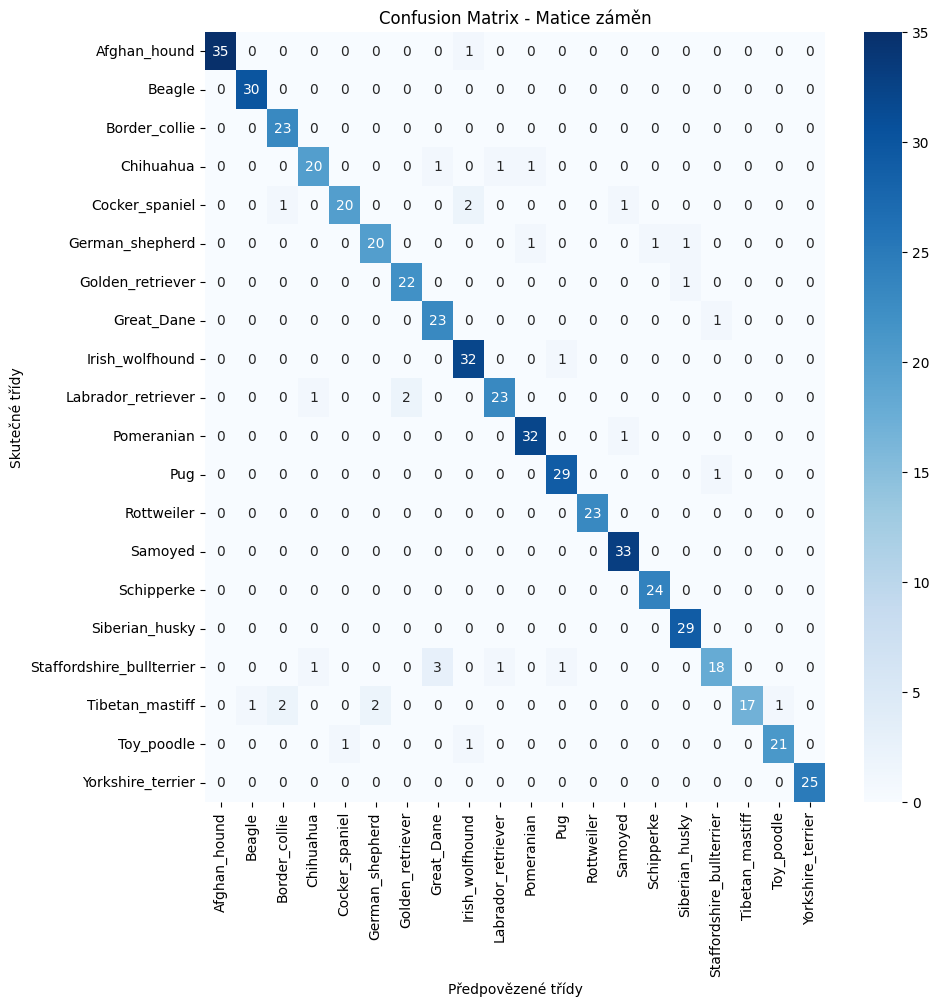

In [ ]:
predictions = model3_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

17/17 [==============================] - 3s 159ms/step


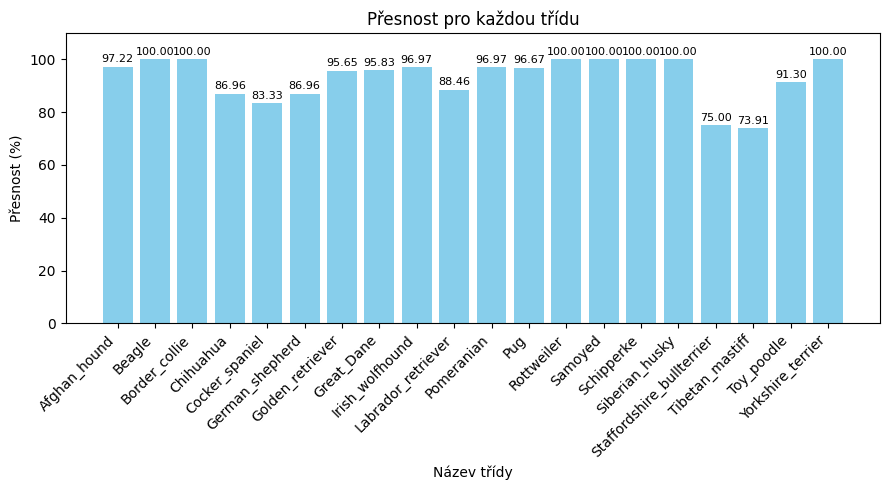

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model3_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()

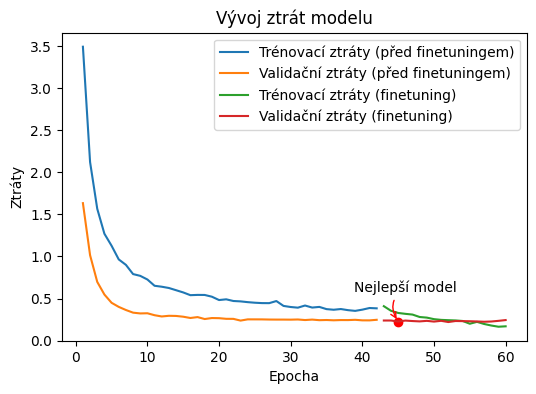

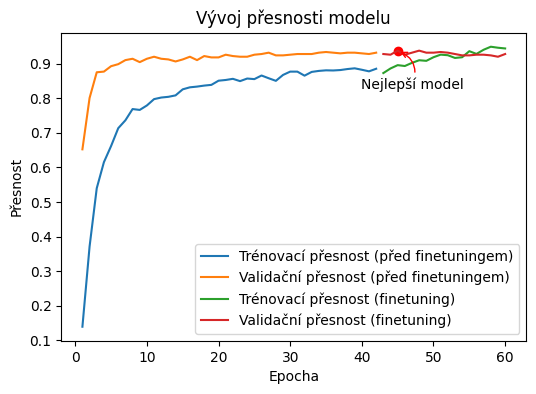

In [ ]:
import matplotlib.pyplot as plt


end_epoch_history2 = 42
epochs_history2 = range(1, end_epoch_history2 + 1)
epochs_history_finetune = range(end_epoch_history2 + 1, end_epoch_history2 + 1 + len(history_finetune.history['accuracy']))


best_finetune_epoch = 45
best_finetune_index = best_finetune_epoch - end_epoch_history2 - 1

plt.figure(figsize=(6, 4))
plt.plot(epochs_history2, history2.history['loss'][:end_epoch_history2], label='Trénovací ztráty (před finetuningem)')
plt.plot(epochs_history2, history2.history['val_loss'][:end_epoch_history2], label='Validační ztráty (před finetuningem)')
plt.plot(epochs_history_finetune, history_finetune.history['loss'], label='Trénovací ztráty (finetuning)')
plt.plot(epochs_history_finetune, history_finetune.history['val_loss'], label='Validační ztráty (finetuning)')
plt.scatter(best_finetune_epoch, history_finetune.history['val_loss'][best_finetune_index], color='red')
plt.annotate('Nejlepší model', xy=(best_finetune_epoch, history_finetune.history['val_loss'][best_finetune_index]),
             xytext=(best_finetune_epoch + 1, history_finetune.history['val_loss'][best_finetune_index] + 0.315),
             textcoords="data", ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', color='red'))
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_history2, history2.history['accuracy'][:end_epoch_history2], label='Trénovací přesnost (před finetuningem)')
plt.plot(epochs_history2, history2.history['val_accuracy'][:end_epoch_history2], label='Validační přesnost (před finetuningem)')
plt.plot(epochs_history_finetune, history_finetune.history['accuracy'], label='Trénovací přesnost (finetuning)')
plt.plot(epochs_history_finetune, history_finetune.history['val_accuracy'], label='Validační přesnost (finetuning)')
plt.scatter(best_finetune_epoch, history_finetune.history['val_accuracy'][best_finetune_index], color='red')
plt.annotate('Nejlepší model', xy=(best_finetune_epoch, history_finetune.history['val_accuracy'][best_finetune_index]),
             xytext=(best_finetune_epoch + 2, history_finetune.history['val_accuracy'][best_finetune_index] - 0.12),
             textcoords="data", ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', color='red'))
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')
plt.show()

17/17 [==============================] - 3s 161ms/step


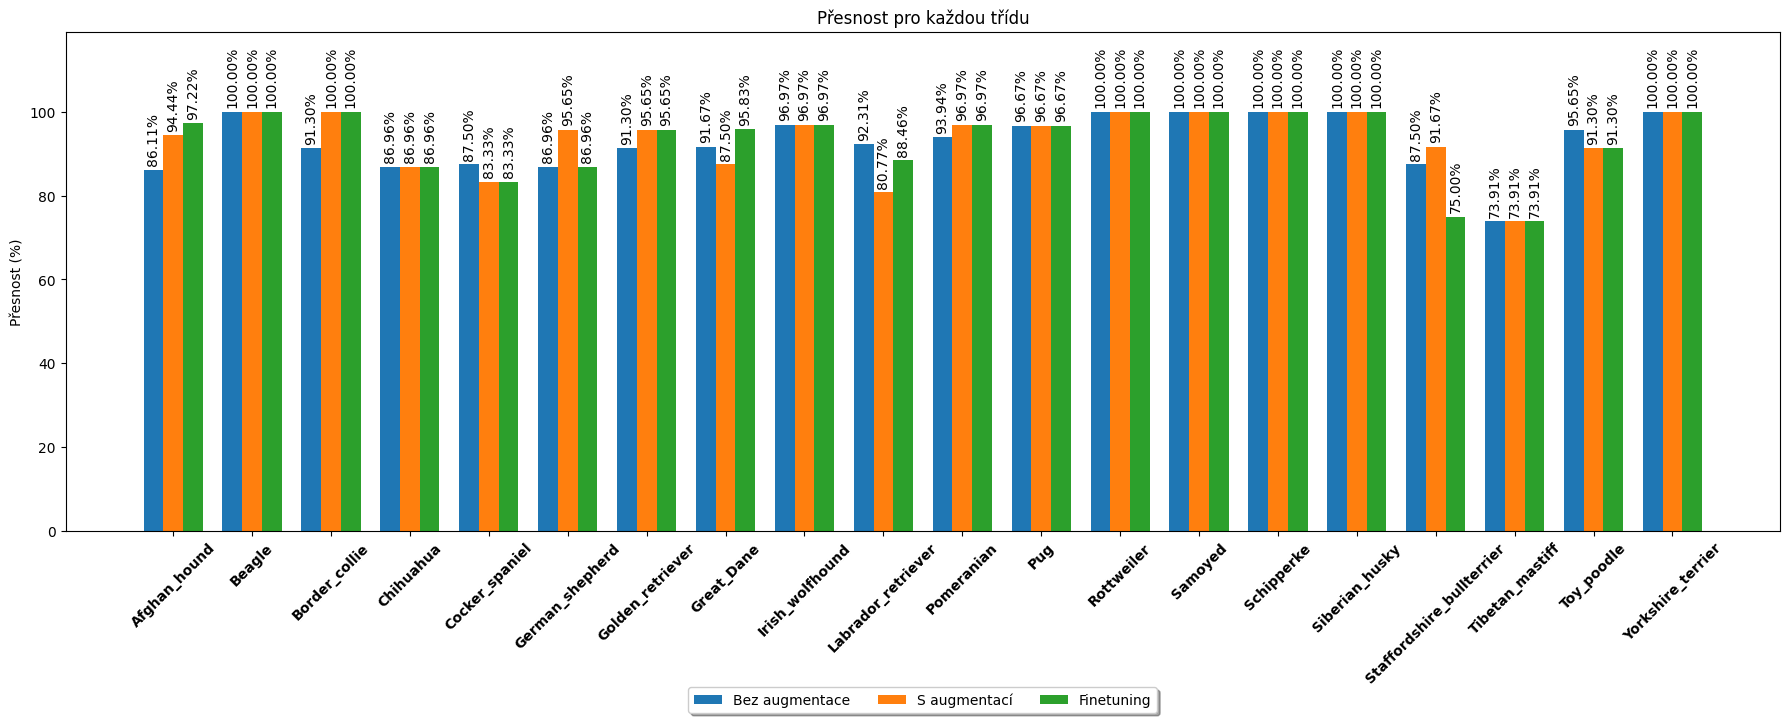

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions1 = model1_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predictions2 = model2_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predictions3 = model3_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

y_pred1 = np.argmax(predictions1, axis=1)
y_pred2 = np.argmax(predictions2, axis=1)
y_pred3 = np.argmax(predictions3, axis=1)

y_true = test_generator.classes

cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(y_true, y_pred3)

accuracy1 = 100 * np.diag(cm1) / np.sum(cm1, axis=1)
accuracy2 = 100 * np.diag(cm2) / np.sum(cm2, axis=1)
accuracy3 = 100 * np.diag(cm3) / np.sum(cm3, axis=1)

class_names = list(test_generator.class_indices.keys())

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(x - width, accuracy1, width, label='Bez augmentace')
rects2 = ax.bar(x, accuracy2, width, label='S augmentací')
rects3 = ax.bar(x + width, accuracy3, width, label='Finetuning')

ax.set_ylabel('Přesnost (%)')
ax.set_title('Přesnost pro každou třídu')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=True, ncol=3)
ax.set_ylim(0, max(max(accuracy1), max(accuracy2), max(accuracy3)) + 19)
def autolabel(rects):
    """Připojí popisek nad každý sloupec zobrazující jeho výšku."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)
fig.subplots_adjust(top=1, bottom=0.1)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()


In [ ]:
import os

model_path = '/content/drive/My Drive/GAP2DSGD/'

if not os.path.exists(model_path):
    os.makedirs(model_path)


model1_loaded.save(model_path + 'GAPmodel1_loaded.keras', save_format='tf')
model2_loaded.save(model_path + 'GAPmodel2_loaded.keras', save_format='tf')
model3_loaded.save(model_path + 'GAPmodel3_loaded.keras', save_format='tf')

In [ ]:
# Model 1
train_loss, train_accuracy = model1_loaded.evaluate(train_generator)
print(f"Trénovací ztráta: {train_loss}, Trénovací přesnost: {train_accuracy}")

valid_loss, valid_accuracy = model1_loaded.evaluate(validation_generator)
print(f"Validační ztráta: {valid_loss}, Validační přesnost: {valid_accuracy}")

test_loss, test_accuracy = model1_loaded.evaluate(test_generator)
print(f"Testovací ztráta: {test_loss}, Testovací přesnost: {test_accuracy}")

# Model 2
train_loss2, train_accuracy2 = model2_loaded.evaluate(train_generator)
print(f"Trénovací ztráta modelu 2: {train_loss2}, Trénovací přesnost modelu 2: {train_accuracy2}")

valid_loss2, valid_accuracy2 = model2_loaded.evaluate(validation_generator)
print(f"Validační ztráta modelu 2: {valid_loss2}, Validační přesnost modelu 2: {valid_accuracy2}")

test_loss2, test_accuracy2 = model2_loaded.evaluate(test_generator)
print(f"Testovací ztráta modelu 2: {test_loss2}, Testovací přesnost modelu 2: {test_accuracy2}")

# Model 3
train_loss3, train_accuracy3 = model3_loaded.evaluate(train_generator)
print(f"Trénovací ztráta modelu 3: {train_loss3}, Trénovací přesnost modelu 3: {train_accuracy3}")

valid_loss3, valid_accuracy3 = model3_loaded.evaluate(validation_generator)
print(f"Validační ztráta modelu 3: {valid_loss3}, Validační přesnost modelu 3: {valid_accuracy3}")

test_loss3, test_accuracy3 = model3_loaded.evaluate(test_generator)
print(f"Testovací ztráta modelu 3: {test_loss3}, Testovací přesnost modelu 3: {test_accuracy3}")

77/77 [==============================] - 33s 419ms/step - loss: 0.1893 - accuracy: 0.9507
Trénovací ztráta: 0.18927334249019623, Trénovací přesnost: 0.9507389068603516
17/17 [==============================] - 4s 208ms/step - loss: 0.2483 - accuracy: 0.9322
Validační ztráta: 0.24826832115650177, Validační přesnost: 0.9322034120559692
17/17 [==============================] - 2s 117ms/step - loss: 0.2235 - accuracy: 0.9323
Testovací ztráta: 0.22349968552589417, Testovací přesnost: 0.932330846786499
77/77 [==============================] - 32s 409ms/step - loss: 0.1207 - accuracy: 0.9680
Trénovací ztráta modelu 2: 0.12068310379981995, Trénovací přesnost modelu 2: 0.9679803252220154
17/17 [==============================] - 2s 115ms/step - loss: 0.2358 - accuracy: 0.9322
Validační ztráta modelu 2: 0.2358434796333313, Validační přesnost modelu 2: 0.9322034120559692
17/17 [==============================] - 3s 142ms/step - loss: 0.1951 - accuracy: 0.9398
Testovací ztráta modelu 2: 0.19507047533

In [ ]:
import pandas as pd

data = {
    'Model': ['Bez Augmentace', 'S Augmentací', 'mensiLR'],
    'Trénovací Ztráta': [train_loss, train_loss2, train_loss3],
    'Trénovací Přesnost': [train_accuracy, train_accuracy2, train_accuracy3],
    'Validační Ztráta': [valid_loss, valid_loss2, valid_loss3],
    'Validační Přesnost': [valid_accuracy, valid_accuracy2, valid_accuracy3],
    'Testovací Ztráta': [test_loss, test_loss2, test_loss3],
    'Testovací Přesnost': [test_accuracy, test_accuracy2, test_accuracy3]
}

results_df = pd.DataFrame(data)

print(results_df)

            Model  Trénovací Ztráta  Trénovací Přesnost  Validační Ztráta  \
0  Bez Augmentace          0.189273            0.950739          0.248268   
1    S Augmentací          0.120683            0.967980          0.235843   
2         mensiLR          0.103548            0.972496          0.228174   

   Validační Přesnost  Testovací Ztráta  Testovací Přesnost  
0            0.932203          0.223500            0.932331  
1            0.932203          0.195070            0.939850  
2            0.935970          0.194586            0.937970  


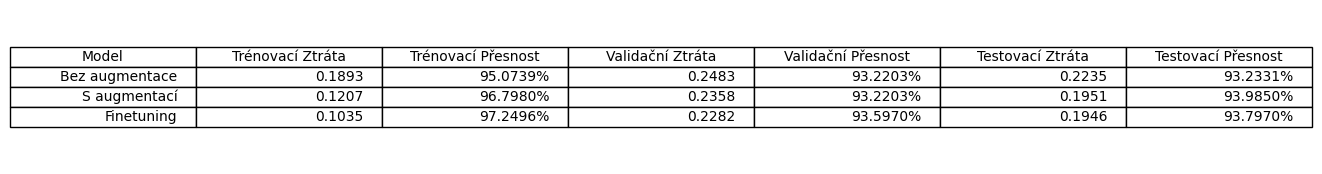

In [ ]:
import matplotlib.pyplot as plt

data = [
    ["Bez augmentace", format(train_loss, ".4f"), format(train_accuracy, ".4%"), format(valid_loss, ".4f"), format(valid_accuracy, ".4%"), format(test_loss, ".4f"), format(test_accuracy, ".4%")],
    ["S augmentací", format(train_loss2, ".4f"), format(train_accuracy2, ".4%"), format(valid_loss2, ".4f"), format(valid_accuracy2, ".4%"), format(test_loss2, ".4f"), format(test_accuracy2, ".4%")],
    ["Finetuning", format(train_loss3, ".4f"), format(train_accuracy3, ".4%"), format(valid_loss3, ".4f"), format(valid_accuracy3, ".4%"), format(test_loss3, ".4f"), format(test_accuracy3, ".4%")]
]

columns = ('Model', 'Trénovací Ztráta', 'Trénovací Přesnost', 'Validační Ztráta', 'Validační Přesnost', 'Testovací Ztráta', 'Testovací Přesnost')

fig, ax = plt.subplots(figsize=(14, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data, colLabels=columns, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()